In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [41]:
# Estructura base DCEL con métodos mágicos para visualización
class Vertex:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.incident_edge = None  # Semi-arista incidente

    def __repr__(self):
        return f"Vertex({self.x}, {self.y})"

    def __str__(self):
        return f"V({self.x}, {self.y})"


class HalfEdge:
    def __init__(self, origin):
        self.origin = origin
        self.twin = None
        self.next = None
        self.prev = None
        self.incident_face = None  # Cara a la izquierda

    def __repr__(self):
        twin_info = f" → Twin({self.twin.origin})" if self.twin else " → No Twin"
        return f"HalfEdge({self.origin}){twin_info}"

    def __str__(self):
        return f"E({self.origin} → {self.twin.origin if self.twin else 'None'})"


class Face:
    def __init__(self):
        self.outer_component = None  # Semi-arista de la frontera exterior
        self.inner_components = []  # Posibles islas interiores

    def __repr__(self):
        return f"Face(Outer: {self.outer_component})"

    def __str__(self):
        return f"F(Outer: {self.outer_component})"


class DCEL:
    def __init__(self):
        self.vertices = []
        self.edges = []
        self.faces = []

    def add_vertex(self, x, y):
        v = Vertex(x, y)
        self.vertices.append(v)
        return v

    def add_edge(self, v1, v2):
        e1 = HalfEdge(v1)
        e2 = HalfEdge(v2)
        e1.twin = e2
        e2.twin = e1
        self.edges.append(e1)
        self.edges.append(e2)
        return e1, e2

    def __repr__(self):
        return f"DCEL(Vertices: {len(self.vertices)}, Edges: {len(self.edges)}, Faces: {len(self.faces)})"

    def __str__(self):
        vertices_str = ", ".join(str(v) for v in self.vertices)
        edges_str = ", ".join(str(e) for e in self.edges)
        faces_str = ", ".join(str(f) for f in self.faces)
        return f"DCEL:\n  Vertices: {vertices_str}\n  Edges: {edges_str}\n  Faces: {faces_str}"


def find_common_edges(dcel1, dcel2):
    """
    Encuentra semi-aristas comunes entre dos DCELs comparando por coordenadas.
    """
    common_edges = []
    
    for edge1 in dcel1.edges:
        for edge2 in dcel2.edges:
            if ((edge1.origin.x, edge1.origin.y) == (edge2.twin.origin.x, edge2.twin.origin.y) and 
                (edge1.twin.origin.x, edge1.twin.origin.y) == (edge2.origin.x, edge2.origin.y)):
                common_edges.append((edge1, edge2))

    print(f"Aristas en común: {len(common_edges)}")
    return common_edges





def visualize_multiple_dcel(dcel_list):
    """
    Función para visualizar múltiples DCELs en una sola imagen.
    
    :param dcel_list: Lista de objetos DCEL a visualizar.
    """
    G = nx.DiGraph()  # Grafo dirigido para representar todas las DCELs
    vertex_ids = {}  # Diccionario de identificadores de vértices globales

    # Crear identificadores únicos de vértices por DCEL
    for dcel_idx, dcel in enumerate(dcel_list):
        for idx, v in enumerate(dcel.vertices):
            vertex_ids[v] = f"V{dcel_idx+1}_{idx+1}"

    # Crear posiciones de los vértices en formato compatible con NetworkX
    vertex_positions = {vertex_ids[v]: (v.x, v.y) for dcel in dcel_list for v in dcel.vertices}

    # Agregar nodos (vértices) al grafo
    for v_id in vertex_positions.keys():
        G.add_node(v_id, pos=vertex_positions[v_id])

    # Agregar semi-aristas al grafo
    edge_labels = {}
    for dcel in dcel_list:
        for edge in dcel.edges:
            if edge.next:  # Evita mostrar aristas sin conexión
                u, v = vertex_ids[edge.origin], vertex_ids[edge.next.origin]
                G.add_edge(u, v)
                edge_labels[(u, v)] = f"{u} → {v}"

    # Configurar la figura
    plt.figure(figsize=(8, 8))
    pos = vertex_positions

    # Dibujar nodos (vértices)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=8)

    # Dibujar etiquetas de las aristas
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=7)

    # Mostrar el gráfico
    plt.title("Visualización de Múltiples DCEL en una Sola Imagen")
    plt.show()




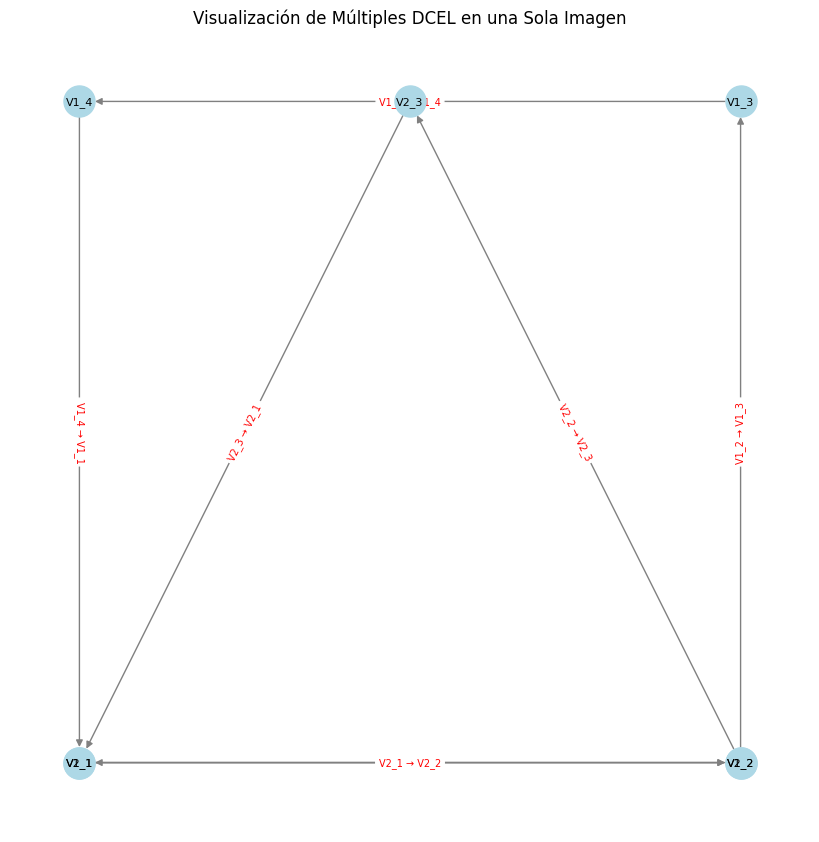

Aristas en común: 2


[(HalfEdge(V(0, 0)) → Twin(V(4, 0)), HalfEdge(V(4, 0)) → Twin(V(0, 0))),
 (HalfEdge(V(4, 0)) → Twin(V(0, 0)), HalfEdge(V(0, 0)) → Twin(V(4, 0)))]

: 

In [ ]:
# Crear un polígono simple con DCEL (cuadrado)
dcel1 = DCEL()
v1 = dcel1.add_vertex(0, 0)
v2 = dcel1.add_vertex(4, 0)
v3 = dcel1.add_vertex(4, 4)
v4 = dcel1.add_vertex(0, 4)

# Crear semi-aristas y sus twins
e1, e2 = dcel1.add_edge(v1, v2)
e3, e4 = dcel1.add_edge(v2, v3)
e5, e6 = dcel1.add_edge(v3, v4)
e7, e8 = dcel1.add_edge(v4, v1)

# Conectar las semi-aristas en sentido antihorario (frontera exterior)
e1.next, e1.prev = e3, e7
e3.next, e3.prev = e5, e1
e5.next, e5.prev = e7, e3
e7.next, e7.prev = e1, e5

# Conectar las semi-aristas twin (sentido horario)
e2.next, e2.prev = e8, e4
e4.next, e4.prev = e6, e2
e6.next, e6.prev = e8, e4
e8.next, e8.prev = e2, e6

# Crear una cara interior (la región dentro del cuadrado)
f1 = Face()
f1.outer_component = e1  # Cualquier semi-arista del borde puede representar la cara
for edge in [e1, e3, e5, e7]:
    edge.incident_face = f1  # Todas estas semi-aristas pertenecen a la cara f1

# Crear una cara exterior (la región fuera del cuadrado)
f2 = Face()
f2.outer_component = e2  # Cualquier semi-arista del borde en sentido contrario
for edge in [e2, e4, e6, e8]:
    edge.incident_face = f2  # Estas semi-aristas pertenecen a la cara exterior

# Agregar las caras a la DCEL
dcel1.faces.append(f1)
dcel1.faces.append(f2)


# Crear un segundo polígono (triángulo)
dcel2 = DCEL()
v1_t = dcel2.add_vertex(0, 0)
v2_t = dcel2.add_vertex(4, 0)
v3_t = dcel2.add_vertex(2, 4)


# Crear semi-aristas y sus twins
e1_t, e2_t = dcel2.add_edge(v1_t, v2_t)
e3_t, e4_t = dcel2.add_edge(v2_t, v3_t)
e5_t, e6_t = dcel2.add_edge(v3_t, v1_t)

# Conectar las semi-aristas
e1_t.next, e1_t.prev = e3_t, e5_t
e3_t.next, e3_t.prev = e5_t, e1_t
e5_t.next, e5_t.prev = e1_t, e3_t

#conectar las semi-aristas twin
e2_t.next, e2_t.prev = e4_t, e6_t
e4_t.next, e4_t.prev = e6_t, e2_t
e6_t.next, e6_t.prev = e2_t, e4_t

# Crear una cara y asignarla
f1 = Face()
f1.outer_component = e1_t
for edge in [e1_t, e3_t, e5_t]:
    edge.incident_face = f1

# Crear una cara exterior (la región fuera del cuadrado)
f2 = Face()
f2.outer_component = e2_t  # Cualquier semi-arista del borde en sentido contrario
for edge in [e2_t, e4_t, e6_t]:
    edge.incident_face = f2  

dcel2.faces.append(f1)
dcel2.faces.append(f2)

# Visualizar ambos DCEL
visualize_multiple_dcel([dcel1,dcel2])

find_common_edges(dcel1, dcel2)
